In [1]:
import numpy as np
import pandas as pd
import os

import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import plotly.io as pio
from plotly.subplots import make_subplots
# setting default template to plotly_white for all visualizations
pio.templates.default = "plotly_white"
%matplotlib inline
import gc

import utils_eda as uteda

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

## Load and inspect data

In [2]:
PATH = './input/siim-covid19-detection'
submission = pd.read_csv(os.path.join(PATH,'sample_submission.csv'), index_col=None)
image_df = pd.read_csv(os.path.join(PATH,'train_image_level.csv'), index_col=None)
study_df = pd.read_csv(os.path.join(PATH,'train_study_level.csv'), index_col=None)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
print(f"Train image level csv shape : {image_df.shape}\nTrain study level csv shape : {study_df.shape}")

Train image level csv shape : (6334, 4)
Train study level csv shape : (6054, 5)


In [3]:
image_df.head(2)
len(image_df)

6334

In [4]:
study_df.head(2)
len(study_df)

6054

In [5]:
#get a list of all the files
from tqdm.auto import tqdm

all_files = []
trn_files = uteda.get_files(PATH+'/train')
test_files = uteda.get_files(PATH+'/test')

print(f'number train dcms={len(trn_files)}, number test dcms from test dir={len(test_files)},\nsample_submission.csv has {len(submission)} entries, this includes 1263 images + 1214 studies ')
all_files = trn_files+test_files
# ds=dcmread(all_files[0])
# dir(ds)
# ds.keys

number train dcms=6334, number test dcms from test dir=1263,
sample_submission.csv has 2477 entries, this includes 1263 images + 1214 studies 


In [6]:
def getinfo(ds,col='id'):
    #lets see if the ds file has only studies
    #and what the mix is
    #assumme we are looking at id column
    out = ds[col].map(lambda x:x.split('_')[1])
    print (f'total records={out.shape}')
    print(f'unique vals={set(out)}')
    for val in (set(out)):
        f = lambda x:x==val
        tot = sum(map(f,out))
        print(f'sum {val} = {tot}')
    print('\n')


In [7]:
getinfo(image_df)
getinfo(study_df)
getinfo(submission)

total records=(6334,)
unique vals={'image'}
sum image = 6334


total records=(6054,)
unique vals={'study'}
sum study = 6054


total records=(2477,)
unique vals={'study', 'image'}
sum study = 1214
sum image = 1263




best_from_kaggle_sub## Where are submission files? In test dir!

# Clean data

In [8]:
#get rid of _image and _study
image_df['id']=image_df['id'].map(lambda x: x.split('_')[0])
study_df['id']=study_df['id'].map(lambda x: x.split('_')[0])

# Find the bounding box distribution

In [9]:
#lets find max number bounding boxes in train set bounding boxes
f=lambda x:x.count('{') if type(x) is str else 0
numb_bboxes_per_row=list(map(f,image_df.boxes))
m=max(numb_bboxes_per_row)
print(f'Maximum number of bounding boxes={m}\n')
tots=0
for i in range(0, m+1):
    tot = numb_bboxes_per_row.count(i)
    print(f'number images with {i} bounding boxes={tot}')
    tots+=tot
print(f'\nTotal images={tots}, total with bounding boxes={tots-numb_bboxes_per_row.count(0)}')
# numb_bboxes_per_row

Maximum number of bounding boxes=8

number images with 0 bounding boxes=2040
number images with 1 bounding boxes=973
number images with 2 bounding boxes=3113
number images with 3 bounding boxes=183
number images with 4 bounding boxes=23
number images with 5 bounding boxes=1
number images with 6 bounding boxes=0
number images with 7 bounding boxes=0
number images with 8 bounding boxes=1

Total images=6334, total with bounding boxes=4294


# Create df that ONLY contains images that have numb_boxes bounding boxes

In [57]:
#get all rows that have this many boxes
numb_boxes=3

In [58]:
def get_rows_with_numb_boxes(df, numb_boxes):
    '''
     find dcm files with numb_boxes bounding boxes
     works by finding number of dicts by checking for the first { char in the dict
     param:  df- loaded from train_image_level.csv (there are some images with no bounding boxes
     so the boxes field is blank)
             numb_boxes-return df with rows with this many bounding boxes
     df 
     returns: dataframe
    '''
    f=lambda x:x.count('{') if type(x) is str else 0
    numb_bboxes_per_row=list(map(f,df.boxes))
    mask= map(lambda x:x==numb_boxes,numb_bboxes_per_row)
    return df[list(mask)]

In [59]:
df1=get_rows_with_numb_boxes(image_df,numb_boxes)
# df1=get_rows(image_df,8)#max bounding boxes, just 1 of these
print(f'Dataframe contains { len(df1)} rows with {numb_boxes} bounding boxes')
# df1.head()

Dataframe contains 183 rows with 3 bounding boxes


In [60]:
#reindex start from 0, get rid of old non sequential index 
df1.reset_index(inplace=True, drop=True)
df1.head()

,id,boxes,label,StudyInstanceUID
0,015484acb9cf,"[{'x': 1577.73419, 'y': 325.18694, 'width': 837.69085, 'height': 1124.40052}, {'x': 777.44025, 'y': 320.20068, 'width': 558.46057, 'height': 339.06534}, {'x': 465.79931, 'y': 1018.27639, 'width': 907.49842, 'height': 401.39353}]",opacity 1 1577.73419 325.18694 2415.42504 1449.58746 opacity 1 777.44025 320.20068 1335.9008199999998 659.26602 opacity 1 465.79931 1018.27639 1373.29773 1419.66992,0da60a794140
1,035f51150531,"[{'x': 1111.01882, 'y': 1475.16981, 'width': 844.83008, 'height': 704.75476}, {'x': 1102.2641, 'y': 2337.50943, 'width': 464, 'height': 376.45264}, {'x': 3334.71693, 'y': 1886.64151, 'width': 446.49048, 'height': 770.41516}]",opacity 1 1111.01882 1475.16981 1955.8489 2179.92457 opacity 1 1102.2641 2337.50943 1566.2641 2713.96207 opacity 1 3334.71693 1886.64151 3781.20741 2657.05667,312b098c64a2
2,03dc2e91e74d,"[{'x': 446.11678, 'y': 1310.8, 'width': 1461.6, 'height': 1467.4}, {'x': 1524.91678, 'y': 748.2, 'width': 498.8, 'height': 435}, {'x': 2795.11678, 'y': 475.6, 'width': 1218, 'height': 2383.8}]",opacity 1 446.11678 1310.8 1907.71678 2778.2 opacity 1 1524.91678 748.2 2023.71678 1183.2 opacity 1 2795.11678 475.6 4013.11678 2859.4,2bd907ae6451
3,03ef29864757,"[{'x': 613.74667, 'y': 509.27338, 'width': 404.91998, 'height': 277.58667}, {'x': 850.58671, 'y': 1023.69998, 'width': 511.87994, 'height': 478.77332}, {'x': 2100.99988, 'y': 570.39333, 'width': 593.37329, 'height': 926.98669}]",opacity 1 613.74667 509.27338 1018.66665 786.86005 opacity 1 850.58671 1023.69998 1362.46665 1502.4733 opacity 1 2100.99988 570.39333 2694.37317 1497.38002,e9f977bc280f
4,04bfc50a592b,"[{'x': 630.13552, 'y': 809.1504, 'width': 323.49207, 'height': 612.01196}, {'x': 1915.36062, 'y': 1211.32969, 'width': 434.23706, 'height': 355.5498}, {'x': 2154.3367, 'y': 704.23407, 'width': 221.48999, 'height': 224.40436}]",opacity 1 630.13552 809.1504 953.62759 1421.16236 opacity 1 1915.36062 1211.32969 2349.59768 1566.87949 opacity 1 2154.3367 704.23407 2375.82669 928.63843,dda7e9290f64


# Utility functions

In [14]:
import utils_eda as uteda
from PIL import Image
import os
import json
def copy_dicom_img_to_dir(row, pth_dicom_fles, pth_destdir):
    '''
    row - pandas series
    pth_dicom_fles - 'input/siim-covid19-detection/train/' for ex
    pth_destdir - where all images will wind up (like ''./test_tmp/'')
    return im.shape(height,width) to be logged
    
    ex.
    # copy imag to test dir
    for i in range(MAX_ROWS):
         copy_dicom_img_to_dir(df1.loc[i],TRAIN_DIR ,TEST_DIR )
    
    '''
    study=  row.loc['StudyInstanceUID']
    dcm_file=row.loc['id']
    
    #create a path to the study
    pth =  pth_dicom_fles + row.loc['StudyInstanceUID']

    #get all dicom files from the study
    dcms = uteda.get_files(pth) 

    if (len(dcms)>1):
        #find the correct image
        dcms=list(filter(lambda x:dcm_file in x, dcms))
   
    #get the image
    img=uteda.dicom2array(dcms[0])
    
    #save it to path
    if not os.path.exists(pth_destdir):
        os.mkdir(pth_destdir)

    im = Image.fromarray(img)     
    im.save(pth_destdir+dcm_file+'.png')
    return img.shape

def load_img( pth_destdir, imagename):
    '''
    just loads an image
    ex.
    nme = df1.loc[0,'id']+'.png'
    im= load_img( TEST_DIR, nme)
    '''
    return Image.open(pth_destdir + imagename)
    
def get_boxes(row):
    '''
    Convert the string that contaings bounding boxes 
    into a list of dicts and return
    ex.
    # get boxes
    all_boxes=[]
    for i in range(MAX_ROWS):
        all_boxes.append(get_boxes(df1.loc[i]))
    '''

    if (pd.isnull(row.loc['boxes'])):
        return []
    
    boxes=row.loc['boxes'].replace('\'','"')
    return json.loads(boxes)

In [15]:
## Copy images to test dir and get image bounding boxes

In [16]:
#lets get the boxes for the first MAX_ROWS rows of df1 and save the images associated with the dicom files
import json
MAX_ROWS=min(5,len(df1))
TRAIN_DIR='./input/siim-covid19-detection/train/'
TEST_DIR='./test_tmp/'

# get boxes
all_boxes=[]
for i in range(MAX_ROWS):
    all_boxes.append(get_boxes(df1.loc[i]))

# copy imag to test dir
for i in range(MAX_ROWS):
     copy_dicom_img_to_dir(df1.loc[i],TRAIN_DIR ,TEST_DIR )

print(all_boxes)   

[[], [], [], [], []]


# Plot the image and only ground truth bounding boxes

No handles with labels found to put in legend.


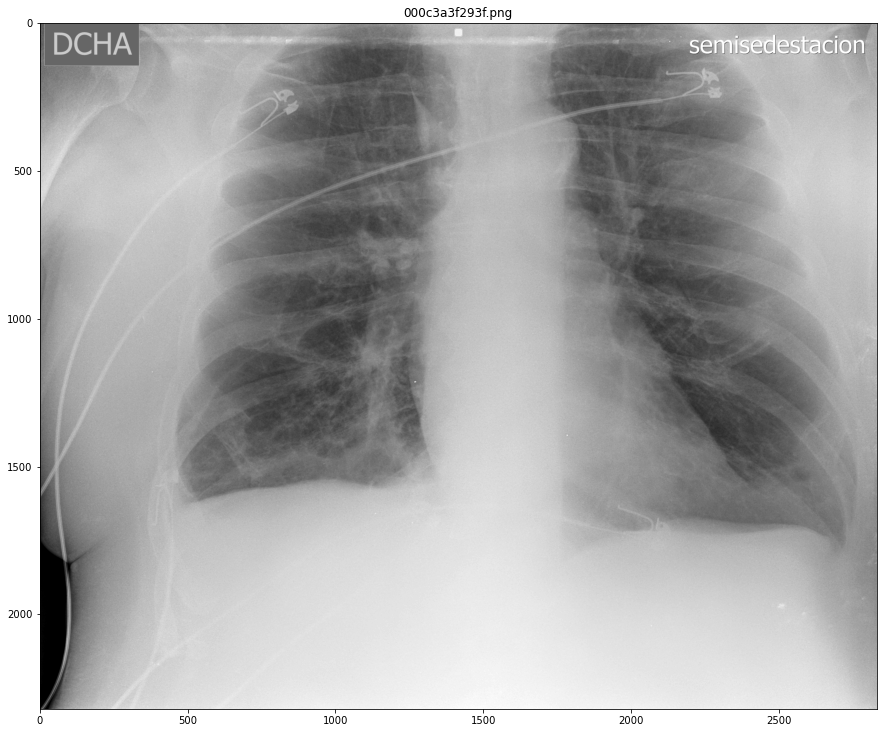

In [17]:
nme = df1.loc[0,'id']+'.png'
im= load_img( TEST_DIR, nme)
im=np.array(im)
height,width = im.shape

boxes=get_boxes(df1.loc[0])

#plot it with the b_boxes
uteda.plot_img_with_bboxes(im, boxes,title=nme, size=15)

# Load a trained yolov5 model and run predictions on files in TEST_DIR.


In [32]:
import os
cwd = os.path.abspath(os.getcwd())

# MODEL1_PATH_2CLASSES ='/artifacts/run_3bh5hck7_model:v199/best.pt'#use alone
MODEL_PATH_1CLASS=cwd +"/best_exp10_yolov5l_img512_1class.pt" #can ensemble with below
MODEL_PATH_1CLASS_KAGGLE = cwd +'/best_from_kaggle_sub_1class.pt'
TEST_DIR=cwd+'/test_tmp/'

#used for debugging yolov5/detect.py in seperate pycharm session
print(MODEL_PATH_1CLASS)
print(MODEL_PATH_1CLASS_KAGGLE)

/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/best_exp10_yolov5l_img512_1class.pt
/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/best_from_kaggle_sub_1class.pt


# Run models, or ensembles of models


In [34]:
# keys= name of the predict output dir
# vals=model weights we are using per run 
model_sel={'ENSEMBLE': MODEL_PATH_1CLASS + " "+MODEL_PATH_1CLASS_KAGGLE,
        'MODEL_PATH_1CLASS': MODEL_PATH_1CLASS,
        'MODEL_PATH_1CLASS_KAGGLE': MODEL_PATH_1CLASS_KAGGLE}

In [33]:
%cd yolov5

for key, val in model_sel.items():   
    %rm -rf ./runs/detect/{key}
    params="--weights " + val+" --source " + TEST_DIR+ "  --img 512 --conf 0.281 --iou-thres 0.5 --max-det 8  --save-txt  --save-conf --name " + key + " --exist-ok"

    !python detect.py {params}
# #get back to correct dir
%cd ..

/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/yolov5
detect: weights=['/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/best_exp10_yolov5l_img512_1class.pt', '/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/best_from_kaggle_sub_1class.pt'], source=/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/test_tmp/, imgsz=512, conf_thres=0.281, iou_thres=0.5, max_det=8, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=ENSEMBLE, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-303-g3bef77f torch 1.9.0+cu102 CUDA:0 (TITAN Xp, 12194.0625MB)

Fusing layers... 
/home/keith/anaconda3/envs/p39/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anyt

## Labels saved to runs/detect/{model_sel key}/labels, 1st is class, last is confidence.  Looks like following
1 0.326869 0.343108 0.252468 0.463613 0.402857 <br>
1 0.695874 0.373716 0.246474 0.478596 0.450281


In [35]:
#list images we tested on
all_files = []
for dirname,_,filenames in os.walk(TEST_DIR):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))
print(all_files)

['/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/test_tmp/010214f9b600.png', '/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/test_tmp/015484acb9cf.png', '/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/test_tmp/04bfc50a592b.png', '/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/test_tmp/035f51150531.png', '/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/test_tmp/000c3a3f293f.png', '/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/test_tmp/03dc2e91e74d.png', '/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/test_tmp/03ef29864757.png', '/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/test_tmp/00c1515729a8.png', '/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/test_tmp/00e3a7e91a34.png', '/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/test_tmp/0023f02ae886.png']


# Get an image, the ground truth bounding boxes, and 1 or more predicted bounding boxes and display

<iframe src="https://www.kaggle.com/embed/rajsengo/beginner-eda-siim-covid-19-detection?cellId=14&cellIds=13&kernelSessionId=64636915" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="[Beginner EDA] SIIM COVID-19 Detection"></iframe>

In [50]:
OUT_DIR='./yolov5/runs/detect/'

# The submisison requires xmin, ymin, xmax, ymax format. 
# YOLOv5 returns x_center, y_center, width, height
def correct_bbox_format(bboxes, orig_width, orig_height):
    correct_bboxes = []
    for b in bboxes:
        xc, yc = int(np.round(b[1]*orig_width)), int(np.round(b[2]*orig_height))
        w, h = int(np.round(b[3]*orig_width)), int(np.round(b[4]*orig_height))

        xmin= xc - int(np.round(w/2))
        ymin= yc - int(np.round(h/2))
        xmax= xc + int(np.round(w/2))
        ymax= yc + int(np.round(h/2))
        conf= b[5]
        
        correct_bboxes.append([xmin, ymin, xmax, ymax, conf])
        
    return correct_bboxes

def get_pred_bboxes(img_name, run_names, run_dir,orig_width=None, orig_height=None):
    '''
    img_name name + suffix
    get all the bounding boxes for img that are stored in multiple run directories
    '''
    if(orig_width is None or orig_height is None):
        im= load_img( TEST_DIR, img_name)
        im=np.array(im)
        orig_height,orig_width = im.shape
    
    results=[]
    for dir in run_names:
        #convert bounding boxes into lists of floats
        pred_boxes_and_confidence=[]
        
        #file to open
        fle = OUT_DIR+dir+ '/labels/' + img_name.split('.')[0] +'.txt'
        if not os.path.isfile(fle):
            print(f'Missing label file for image {img_name} for run {dir}' )
            continue
            
        with open(fle) as f:
            lines=f.readlines()
            for lne in lines:
                lne=lne.replace('\n','')
                lne="[" +lne.replace(' ',',') +"]"
                lne=json.loads(lne)               
                pred_boxes_and_confidence.append(lne)
        pred_boxes = correct_bbox_format(pred_boxes_and_confidence,orig_width,orig_height)
        
        #convert to a dict
        keys=["x1","y1","x2","y2","conf"]
        for i,b in enumerate(pred_boxes):
            pred_boxes[i]=dict(zip(keys,b))
        results.append(pred_boxes)
    return results
    

# Tying it together

In [79]:
#get row of interest
row = df1.loc[0]

img_name = row.loc['id']+'.png'
img= load_img( TEST_DIR, nme)
img=np.array(img)
height,width = img.shape

#ground truth bounding boxes
gt_boxes=get_boxes(row)

#runs I want predictions from
run_names=('ENSEMBLE','MODEL_PATH_1CLASS','MODEL_PATH_1CLASS_KAGGLE')

#get predicted bounding boxes
results = get_pred_bboxes(img_name, run_names, OUT_DIR, orig_width=width, orig_height=height)

# results
# gt_boxes

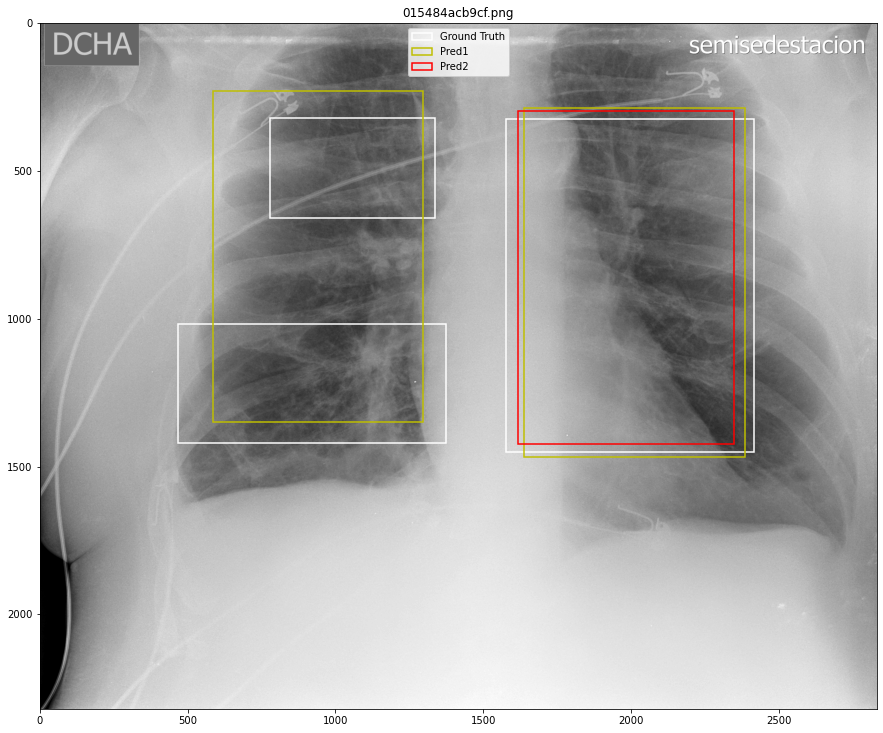

In [83]:
#plot it with the b_boxes
uteda.plot_img_with_bboxes(img, gt_boxes,results[1],results[2],title=img_name, size=15)